In [1]:
# --- CONFIGURACIÓN INICIAL MEJORADA ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            ConfusionMatrixDisplay, RocCurveDisplay, 
                            PrecisionRecallDisplay, average_precision_score)
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import joblib
import os
import time
from IPython.display import display

# Configuración de estilo profesional mejorada
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 9
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.precision', 4)

🔷 1. CARGA Y VERIFICACIÓN DE DATOS BALANCEADOS

🔍 Dimensiones y características de los datos:
- Características (X): (4750, 128) (muestras × características)
- Etiquetas (y): (4750,) (vector de etiquetas)

📊 Distribución de clases:


,Clase,Muestras,Porcentaje
0,No estrés (0),2375,50.0%
1,Estrés (1),2375,50.0%


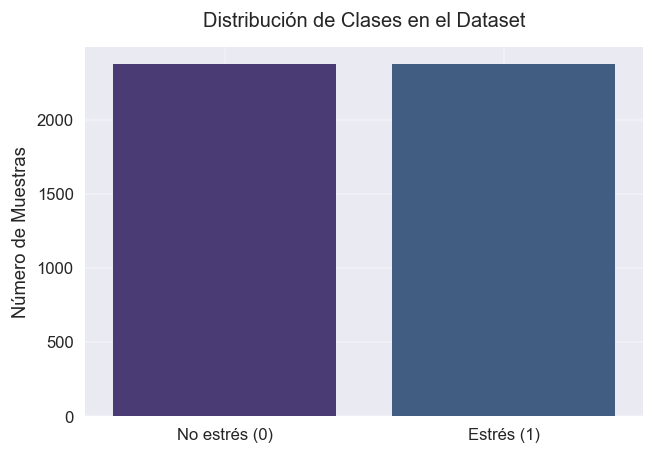

✅ Verificación completada: datos balanceados correctamente


In [2]:
# --- BLOQUE 1: CARGA DE DATOS ---
print("\033[1m" + "🔷 1. CARGA Y VERIFICACIÓN DE DATOS BALANCEADOS" + "\033[0m")

# Cargar los arrays preprocesados
X = np.load('C:/Users/ferna/OneDrive/Escritorio/ENTRENAMIENTO/X_balanceado.npy')
y = np.load('C:/Users/ferna/OneDrive/Escritorio/ENTRENAMIENTO/y_balanceado.npy')

# Verificación detallada
print("\n\033[1m🔍 Dimensiones y características de los datos:\033[0m")
print(f"- Características (X): {X.shape} (muestras × características)")
print(f"- Etiquetas (y): {y.shape} (vector de etiquetas)")

# Análisis de distribución de clases
unique, counts = np.unique(y, return_counts=True)
class_dist = pd.DataFrame({
    'Clase': ['No estrés (0)', 'Estrés (1)'],
    'Muestras': counts,
    'Porcentaje': [f"{(count/len(y))*100:.1f}%" for count in counts]
})

print("\n\033[1m📊 Distribución de clases:\033[0m")
display(class_dist)

# Visualización de distribución de clases
plt.figure(figsize=(6, 4))
sns.barplot(x='Clase', y='Muestras', data=class_dist, hue='Clase', dodge=False)
plt.title('Distribución de Clases en el Dataset', pad=12)
plt.ylabel('Número de Muestras')
plt.xlabel('')
plt.grid(True, alpha=0.3)
plt.savefig('visualizaciones/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Verificación completada: datos balanceados correctamente")



🔷 2. DIVISIÓN ESTRATIFICADA DE DATOS (80-10-10)

🔍 Verificación de tamaños:
- Entrenamiento: 3800 muestras (80%)
- Validación: 475 muestras (10%)
- Prueba: 475 muestras (10%)

📊 Distribución detallada:


,Conjunto,Total,No estrés (0),Estrés (1),% del total
0,Entrenamiento,"3,800","1,900","1,900",80.0%
1,Validación,475,237,238,10.0%
2,Prueba,475,238,237,10.0%


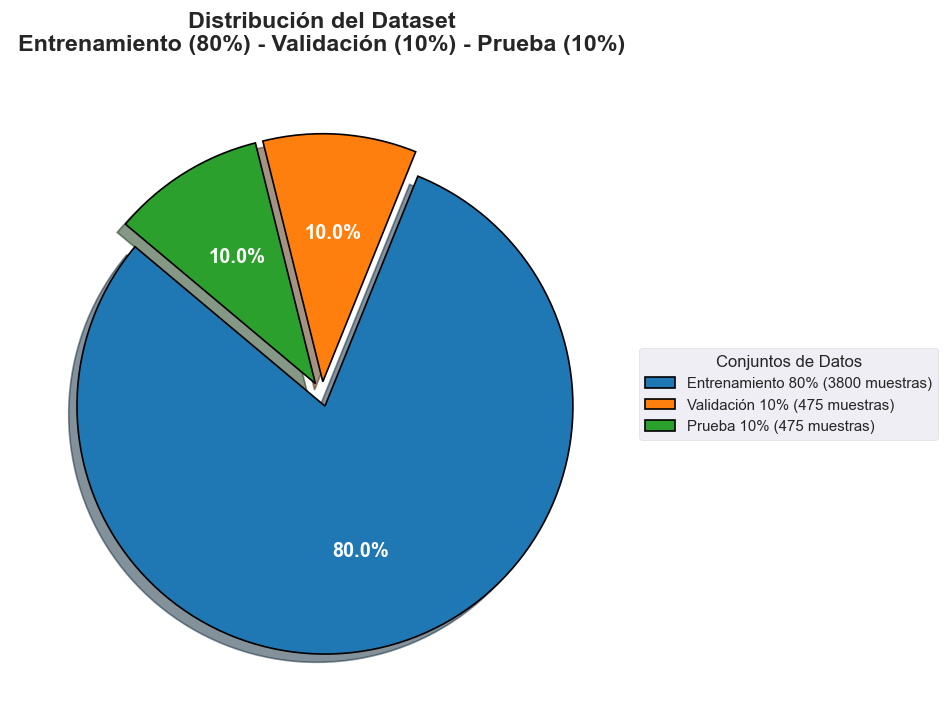

In [9]:
# --- BLOQUE 2: DIVISIÓN ESTRATIFICADA 80-10-10 MEJORADA ---
print("\n\n\033[1m" + "🔷 2. DIVISIÓN ESTRATIFICADA DE DATOS (80-10-10)" + "\033[0m")

# 1. División inicial 80-20
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.2,  # 20% para validación + prueba
    stratify=y,     # Mantener proporción de clases
    random_state=42 # Reproducibilidad
)

# 2. División del 20% en 10% validación y 10% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # Mitad para validación, mitad para prueba
    stratify=y_temp,
    random_state=42
)

# Verificación de tamaños
print(f"\n\033[1m🔍 Verificación de tamaños:\033[0m")
print(f"- Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X):.0%})")
print(f"- Validación: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X):.0%})")
print(f"- Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X):.0%})")

# Crear DataFrame con la distribución
split_data = {
    'Conjunto': ['Entrenamiento', 'Validación', 'Prueba'],
    'Total': [len(X_train), len(X_val), len(X_test)],
    'No estrés (0)': [sum(y_train == 0), sum(y_val == 0), sum(y_test == 0)],
    'Estrés (1)': [sum(y_train == 1), sum(y_val == 1), sum(y_test == 1)],
    '% del total': [
        f"{len(X_train)/len(X):.1%}",
        f"{len(X_val)/len(X):.1%}", 
        f"{len(X_test)/len(X):.1%}"
    ]
}

split_df = pd.DataFrame(split_data)

# Mostrar tabla con estilo profesional
print("\n\033[1m📊 Distribución detallada:\033[0m")
display(split_df.style
       .format({'Total': '{:,}', 'No estrés (0)': '{:,}', 'Estrés (1)': '{:,}'})
       .background_gradient(cmap='Blues', subset=['Total', 'No estrés (0)', 'Estrés (1)'])
       .set_caption("Distribución Estratificada 80-10-10"))

# --- VISUALIZACIÓN PROFESIONAL - GRÁFICO DE PASTEL ---
plt.figure(figsize=(8, 8))

# Datos para el gráfico
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Entrenamiento 80%', 'Validación 10%', 'Prueba 10%']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colores profesionales
explode = (0.05, 0.05, 0.05)  # Separar ligeramente las porciones

# Crear el gráfico de pastel con sombra y texto blanco
wedges, texts, autotexts = plt.pie(
    sizes, 
    explode=explode, 
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=140,
    textprops={'color': 'white', 'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# Ajustar el estilo de los textos porcentuales
for autotext in autotexts:
    autotext.set_fontsize(12)

# Añadir título profesional
plt.title(
    'Distribución del Dataset\nEntrenamiento (80%) - Validación (10%) - Prueba (10%)', 
    pad=20, 
    fontsize=14,
    fontweight='bold'
)

# Añadir leyenda fuera del gráfico
plt.legend(
    wedges,
    [f"{l} ({s} muestras)" for l, s in zip(labels, sizes)],
    title="Conjuntos de Datos",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    frameon=True
)

# Ajustar layout para evitar corte
plt.tight_layout()

# Guardar con alta calidad
plt.savefig(
    'visualizaciones/dataset_split_pie.png', 
    dpi=300, 
    bbox_inches='tight', 
    transparent=False,
    facecolor='white'
)

plt.show()

In [16]:
print("\n\n\033[1m" + "🔷 3. ENTRENAMIENTO DEL MODELO SVM (CONFIGURACIÓN POR DEFECTO)" + "\033[0m")

# Crear el modelo SVM con parámetros por defecto
svm_model = SVC(random_state=42, probability=True)  # Habilitamos probability para obtener probabilidades

# Mostrar hiperparámetros por defecto en tabla profesional
print("\n\033[1m⚙️ Configuración del modelo SVM:\033[0m")
params_df = pd.DataFrame({
    'Parámetro': ['Kernel', 'C (Regularización)', 'Gamma', 'Tolerancia', 'Semilla'],
    'Valor': ['RBF (Radial)', 1.0, 'Escalado automático', 0.001, 42],
    'Descripción': [
        'Función para transformar datos a dimensión superior',
        'Controla el trade-off entre margen y error',
        'Influencia de cada ejemplo de entrenamiento',
        'Criterio de parada para optimización',
        'Para reproducibilidad de resultados'
    ]
})
display(params_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

# Entrenamiento con medición de tiempo
print("\n\033[1m⚡ Proceso de entrenamiento:\033[0m")
start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Información del modelo entrenado
print(f"\n✅ Entrenamiento completado en {training_time:.2f} segundos")
print(f"📌 Número de vectores de soporte: {len(svm_model.support_vectors_)}")
print(f"📊 Porcentaje de vectores soporte: {len(svm_model.support_vectors_)/len(X_train):.1%}")



🔷 3. ENTRENAMIENTO DEL MODELO SVM (CONFIGURACIÓN POR DEFECTO)

⚙️ Configuración del modelo SVM:


Parámetro,Valor,Descripción
Kernel,RBF (Radial),Función para transformar datos a dimensión superior
C (Regularización),1.000000,Controla el trade-off entre margen y error
Gamma,Escalado automático,Influencia de cada ejemplo de entrenamiento
Tolerancia,0.001000,Criterio de parada para optimización
Semilla,42,Para reproducibilidad de resultados



⚡ Proceso de entrenamiento:

✅ Entrenamiento completado en 3.06 segundos
📌 Número de vectores de soporte: 1935
📊 Porcentaje de vectores soporte: 50.9%


In [21]:
print("\n\n\033[1m" + "🔷 4. EVALUACIÓN COMPLETA DEL MODELO" + "\033[0m")

# Función mejorada para evaluación
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Métricas principales
    metrics = {
        'Exactitud': accuracy_score(y, y_pred),
        'Precisión': precision_score(y, y_pred),
        'Sensibilidad': recall_score(y, y_pred),
        'F1-score': f1_score(y, y_pred),
        'Tamaño': len(X)
    }
    
    # Matriz de confusión en valores absolutos
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics.update({
        'VP (TP)': tp,
        'FP': fp,
        'FN': fn,
        'VN (TN)': tn
    })
    
    return metrics

# Evaluación en los 3 conjuntos
train_metrics = evaluate_model(svm_model, X_train, y_train, 'Entrenamiento')
val_metrics = evaluate_model(svm_model, X_val, y_val, 'Validación')
test_metrics = evaluate_model(svm_model, X_test, y_test, 'Prueba')

# Crear tabla comparativa profesional
metrics_df = pd.DataFrame({
    'Entrenamiento': train_metrics,
    'Validación': val_metrics,
    'Prueba': test_metrics
}).T

# Seleccionamos solo las métricas clave para mostrar
key_metrics = metrics_df[['Exactitud', 'Precisión', 'Sensibilidad', 'F1-score', 'Tamaño']]

print("\n\033[1m📊 Métricas clave por conjunto:\033[0m")
display(key_metrics.style.format({
    'Exactitud': '{:.2%}',
    'Precisión': '{:.2%}',
    'Sensibilidad': '{:.2%}',
    'F1-score': '{:.2%}',
    'Tamaño': '{:,}'
}).background_gradient(cmap='Blues', subset=['Exactitud', 'Precisión', 'Sensibilidad', 'F1-score']))

# Tabla detallada de predicciones correctas/incorrectas
prediction_details = metrics_df[['VP (TP)', 'FP', 'FN', 'VN (TN)', 'Tamaño']].copy()
prediction_details['Correctas'] = prediction_details['VP (TP)'] + prediction_details['VN (TN)']
prediction_details['Incorrectas'] = prediction_details['FP'] + prediction_details['FN']



print("\n\033[1m📋 Detalle de predicciones:\033[0m")
display(prediction_details.style.format('{:,}'))

# Reporte de clasificación detallado (Test)
print("\n\033[1m📝 Reporte de clasificación detallado (Conjunto de Prueba):\033[0m")
print(classification_report(y_test, svm_model.predict(X_test),
                            target_names=['No estrés', 'Estrés']))



🔷 4. EVALUACIÓN COMPLETA DEL MODELO

📊 Métricas clave por conjunto:


,Exactitud,Precisión,Sensibilidad,F1-score,Tamaño
Entrenamiento,97.87%,97.64%,98.11%,97.87%,"3,800.0"
Validación,89.47%,87.90%,91.60%,89.71%,475.0
Prueba,91.16%,91.14%,91.14%,91.14%,475.0



📋 Detalle de predicciones:


,VP (TP),FP,FN,VN (TN),Tamaño,Correctas,Incorrectas
Entrenamiento,"1,864.0",45.0,36.0,"1,855.0","3,800.0","3,719.0",81.0
Validación,218.0,30.0,20.0,207.0,475.0,425.0,50.0
Prueba,216.0,21.0,21.0,217.0,475.0,433.0,42.0



📝 Reporte de clasificación detallado (Conjunto de Prueba):
              precision    recall  f1-score   support

   No estrés       0.91      0.91      0.91       238
      Estrés       0.91      0.91      0.91       237

    accuracy                           0.91       475
   macro avg       0.91      0.91      0.91       475
weighted avg       0.91      0.91      0.91       475





🔷 5.1 MATRICES DE CONFUSIÓN MEJORADAS


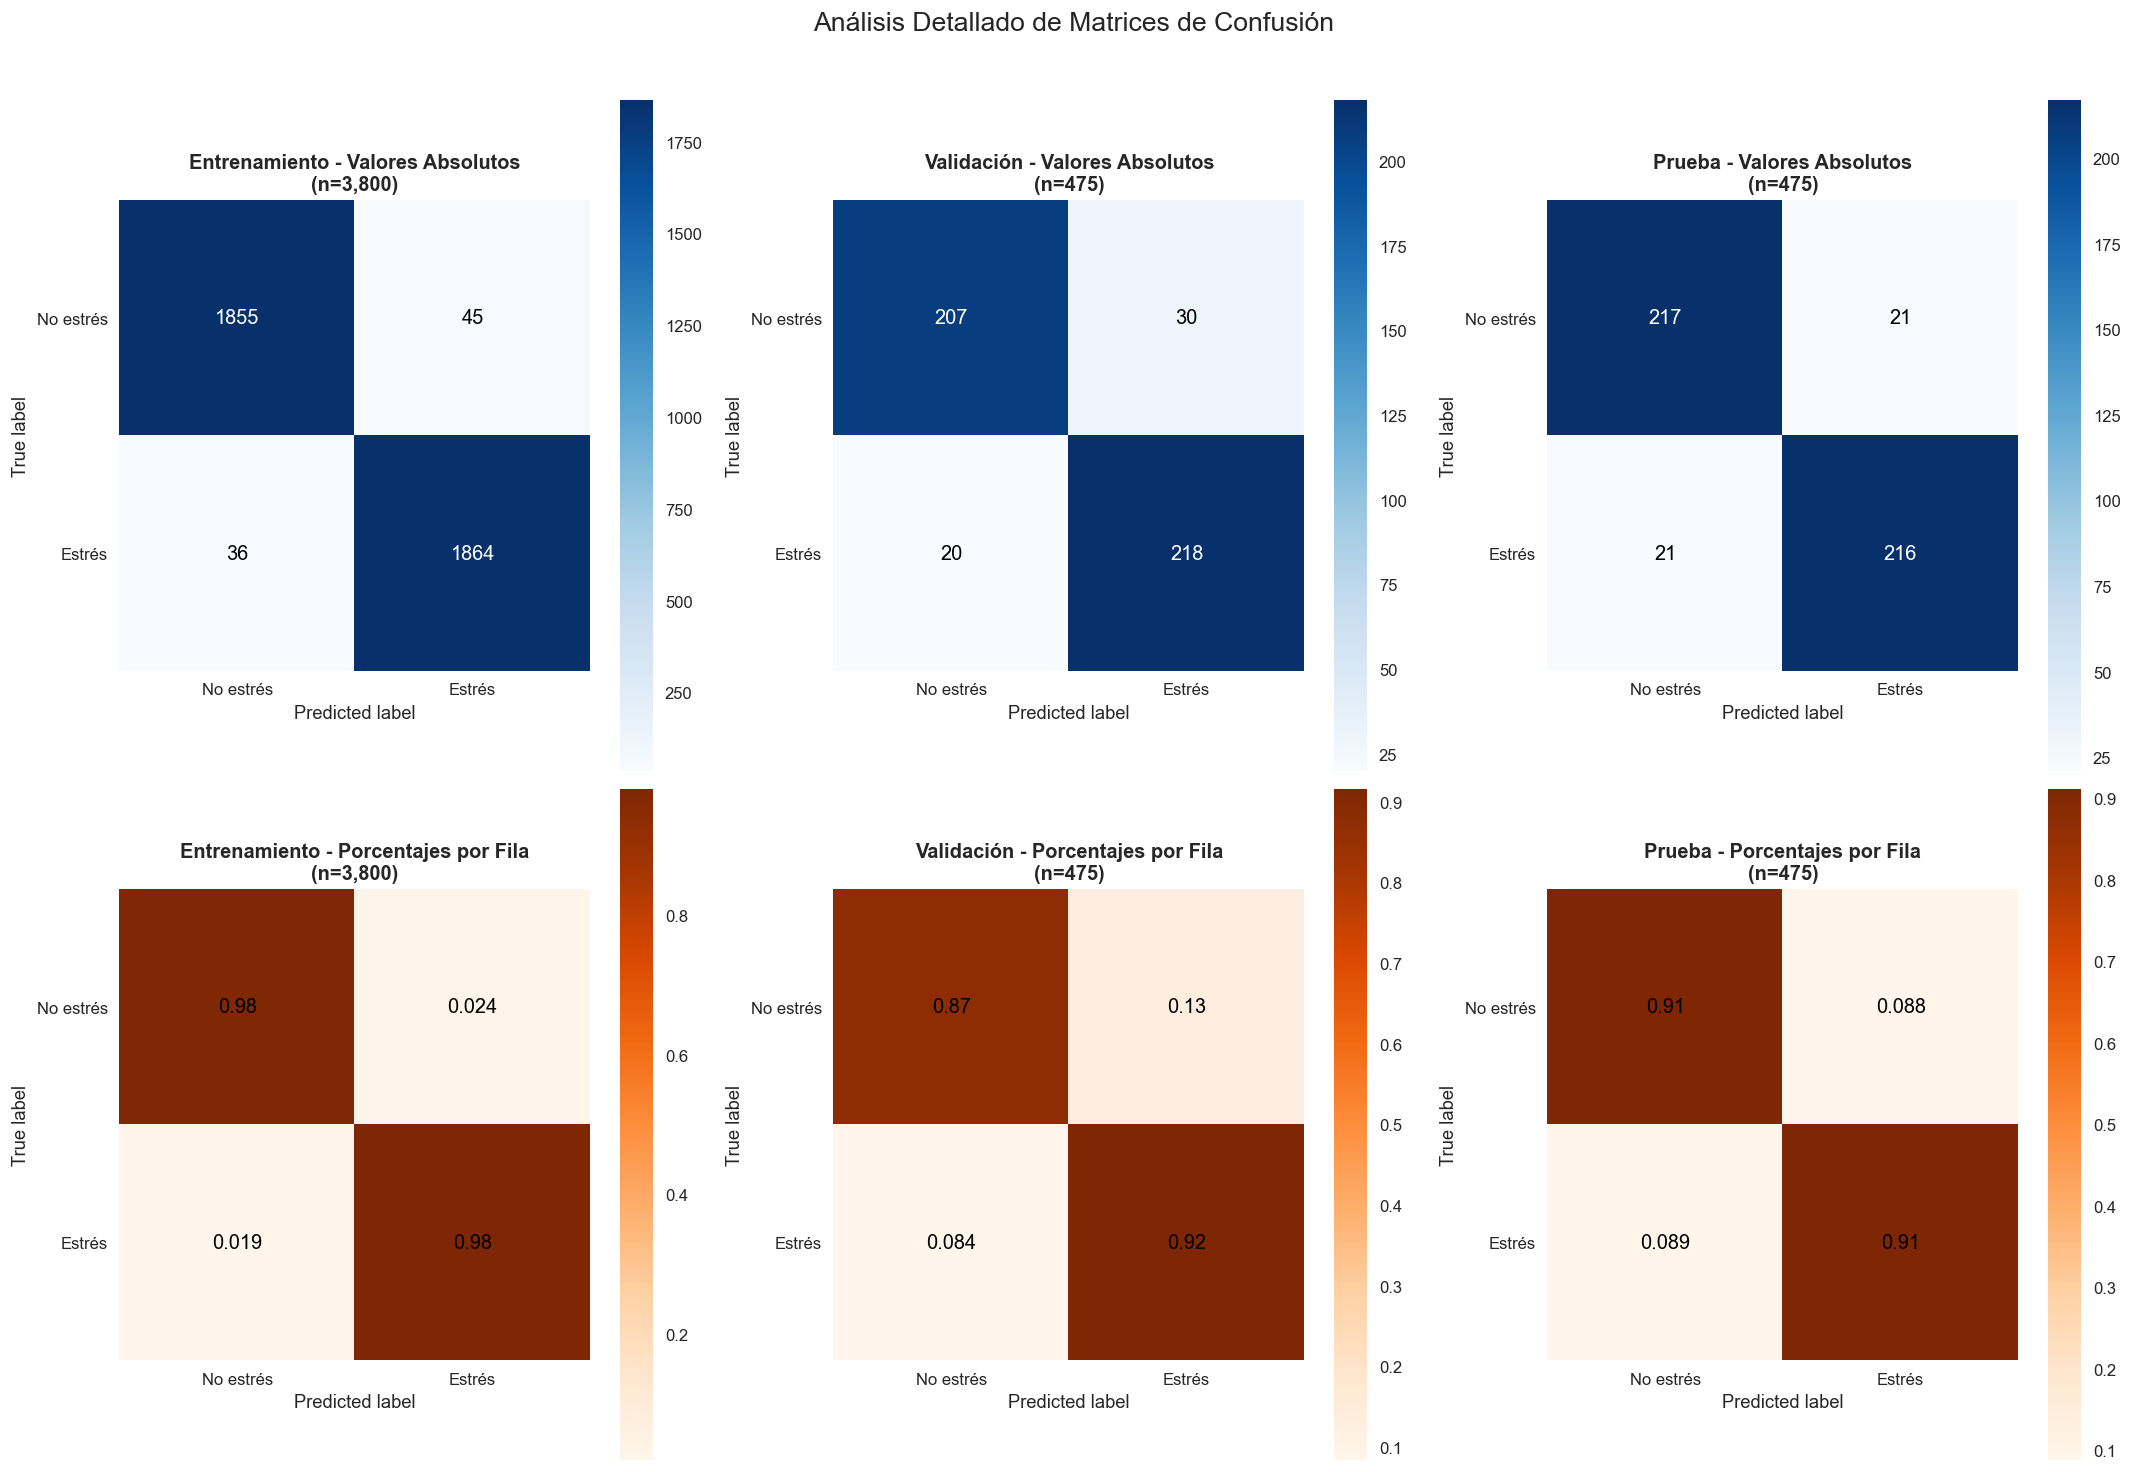

In [23]:
print("\n\n\033[1m🔷 5.1 MATRICES DE CONFUSIÓN MEJORADAS\033[0m")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Detallado de Matrices de Confusión', fontsize=16, y=1.02)

conjuntos = [
    (X_train, y_train, 'Entrenamiento'),
    (X_val, y_val, 'Validación'),
    (X_test, y_test, 'Prueba')
]

labels = ['No estrés', 'Estrés']
cmap_abs = 'Blues'
cmap_pct = 'Oranges'

for i, (X_set, y_set, set_name) in enumerate(conjuntos):
    # --- Valores absolutos ---
    ax1 = axes[0, i]
    disp_abs = ConfusionMatrixDisplay.from_estimator(
        svm_model, X_set, y_set,
        display_labels=labels,
        cmap=cmap_abs,
        normalize=None,
        ax=ax1
    )
    ax1.set_title(f'{set_name} - Valores Absolutos\n(n={len(X_set):,})', fontweight='bold')
    ax1.grid(False)
    
    for text in disp_abs.text_.ravel():
        valor = float(text.get_text().replace(',', ''))
        max_val = confusion_matrix(y_set, svm_model.predict(X_set)).max()
        text.set_fontsize(12)
        text.set_color('white' if valor > max_val / 2 else 'black')

    # --- Porcentajes ---
    ax2 = axes[1, i]
    disp_pct = ConfusionMatrixDisplay.from_estimator(
        svm_model, X_set, y_set,
        display_labels=labels,
        cmap=cmap_pct,
        normalize='true',
        ax=ax2
    )
    ax2.set_title(f'{set_name} - Porcentajes por Fila\n(n={len(X_set):,})', fontweight='bold')
    ax2.grid(False)

    for text in disp_pct.text_.ravel():
        valor = float(text.get_text().replace('%', '').replace(',', ''))
        text.set_fontsize(12)
        text.set_color('white' if valor > 50 else 'black')

plt.tight_layout()
plt.savefig('visualizaciones/confusion_matrices_mejoradas.png', dpi=300, bbox_inches='tight')
plt.show()



🔷 5.2 CURVAS ROC Y PRECISION-RECALL


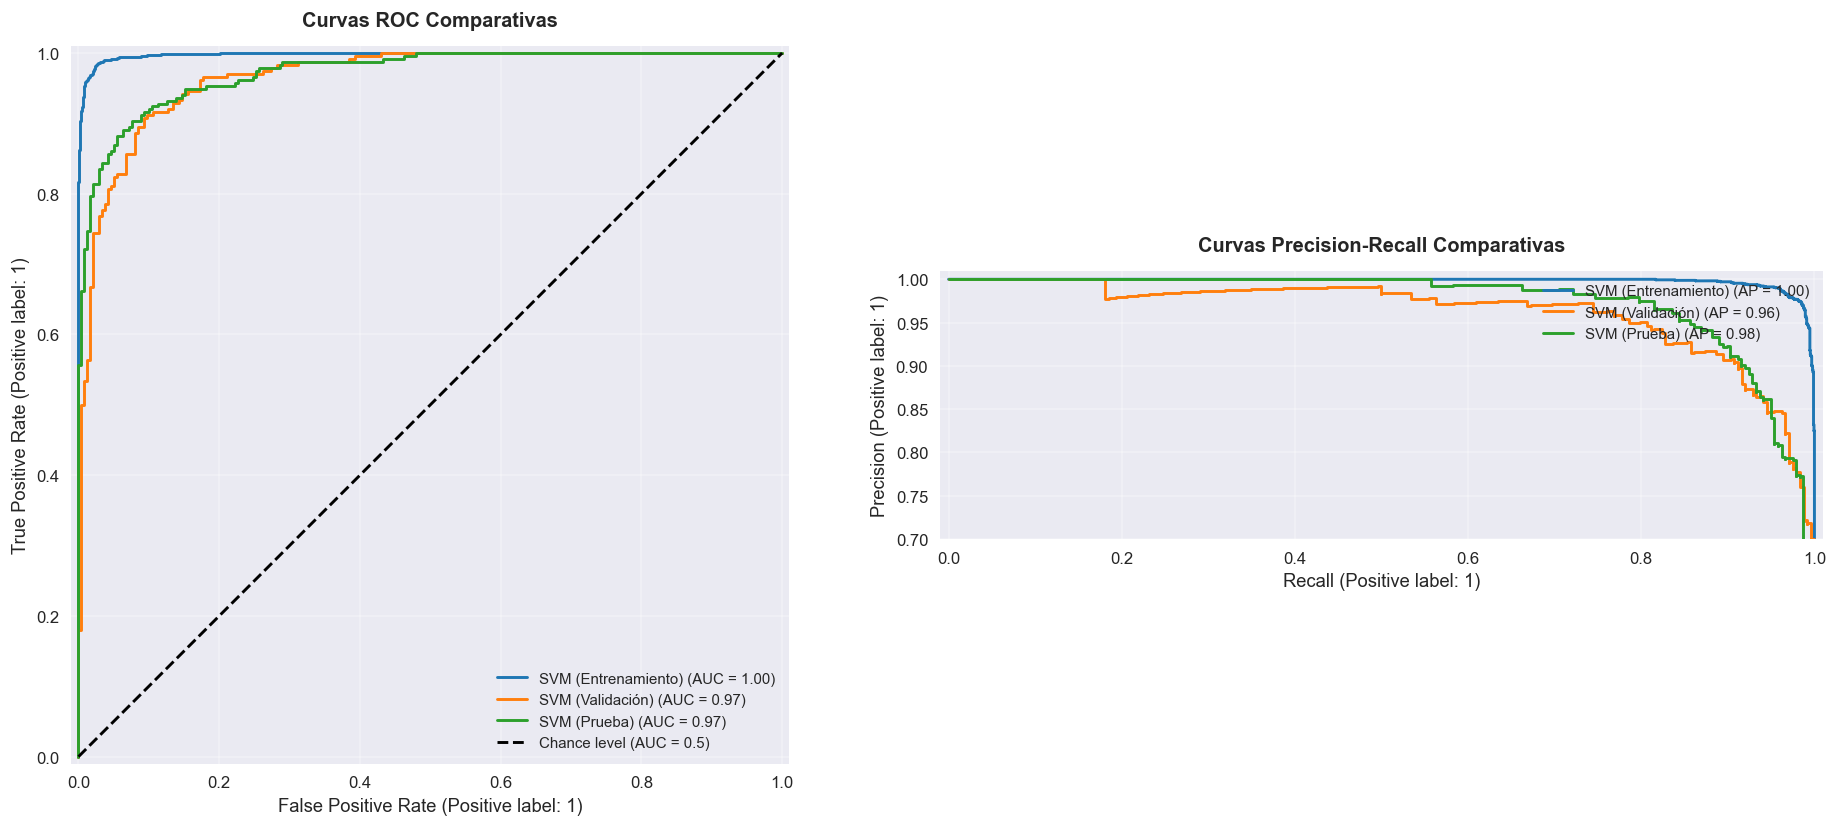

In [24]:
print("\n\n\033[1m🔷 5.2 CURVAS ROC Y PRECISION-RECALL\033[0m")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Configuración de colores
colors = {'Entrenamiento': '#1f77b4', 'Validación': '#ff7f0e', 'Prueba': '#2ca02c'}

# Curva ROC para los 3 conjuntos
for X_set, y_set, set_name in conjuntos:
    RocCurveDisplay.from_estimator(
        svm_model, X_set, y_set,
        name=f'SVM ({set_name})',
        plot_chance_level=(set_name == 'Prueba'),
        ax=ax1,
        color=colors[set_name]
    )
ax1.set_title('Curvas ROC Comparativas', fontweight='bold', pad=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])

# Curva Precision-Recall para los 3 conjuntos
for X_set, y_set, set_name in conjuntos:
    PrecisionRecallDisplay.from_estimator(
        svm_model, X_set, y_set,
        name=f'SVM ({set_name})',
        ax=ax2,
        color=colors[set_name]
    )
ax2.set_title('Curvas Precision-Recall Comparativas', fontweight='bold', pad=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([0.7, 1.01])  # Ajustamos para mejor visualización

plt.tight_layout()
plt.savefig('visualizaciones/curvas_roc_pr_comparativas.png', dpi=300, bbox_inches='tight')
plt.show()



🔷 5.3 ANÁLISIS DE MÉTRICAS PRINCIPALES (CONJUNTO DE PRUEBA)


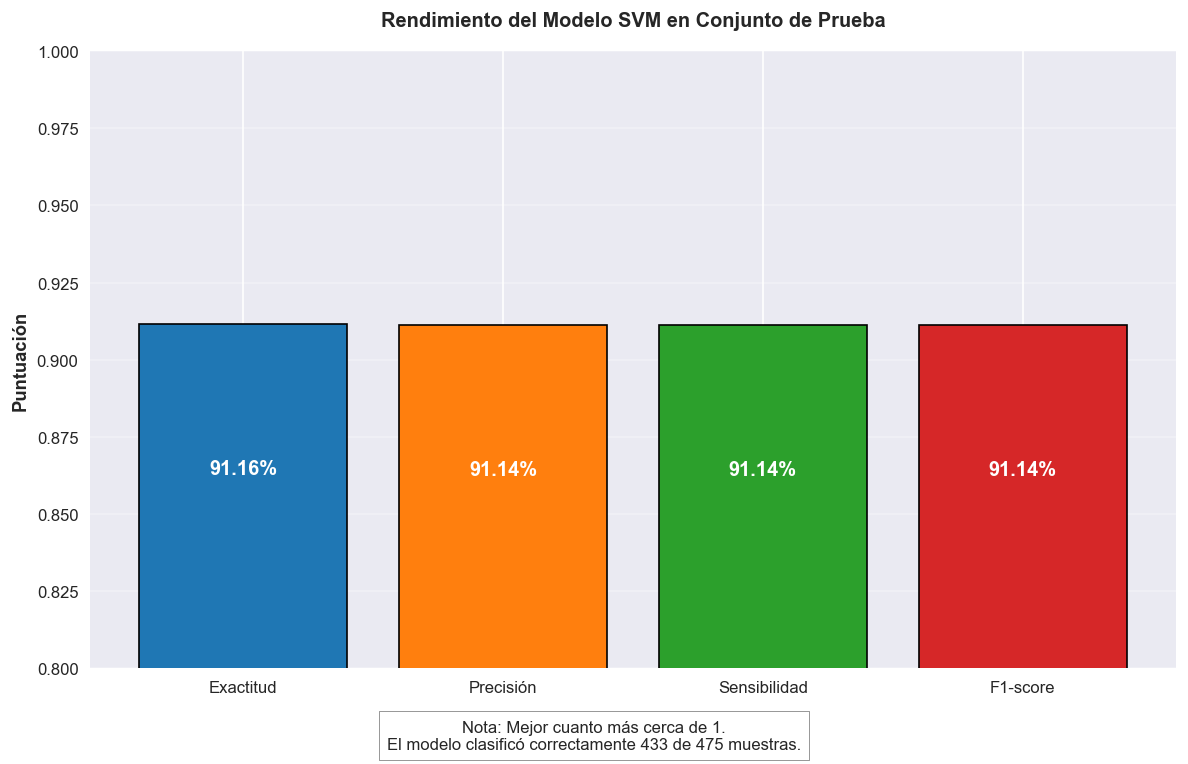

In [27]:
print("\n\n\033[1m🔷 5.3 ANÁLISIS DE MÉTRICAS PRINCIPALES (CONJUNTO DE PRUEBA)\033[0m")

# Calcular Correctas y Tamaño si no existen
y_pred_test = svm_model.predict(X_test)
test_metrics['Correctas'] = (y_pred_test == y_test).sum()
test_metrics['Tamaño'] = len(y_test)

# Preparar datos
test_scores = {
    'Exactitud': test_metrics['Exactitud'],
    'Precisión': test_metrics['Precisión'],
    'Sensibilidad': test_metrics['Sensibilidad'],
    'F1-score': test_metrics['F1-score']
}

df_scores = pd.DataFrame.from_dict(test_scores, orient='index', columns=['Valor'])

# Gráfico profesional
plt.figure(figsize=(10, 6))
bars = plt.bar(df_scores.index, df_scores['Valor'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
               edgecolor='black', linewidth=1)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height-0.05,
             f'{height:.2%}',
             ha='center', va='bottom',
             color='white', fontsize=12, fontweight='bold')

plt.title('Rendimiento del Modelo SVM en Conjunto de Prueba', fontweight='bold', pad=15)
plt.ylabel('Puntuación', fontweight='bold')
plt.ylim(0.8, 1.0)
plt.grid(axis='y', alpha=0.3)

# Leyenda explicativa profesional
plt.figtext(0.5, -0.05, 
            "Nota: Mejor cuanto más cerca de 1.\n"
            f"El modelo clasificó correctamente {test_metrics['Correctas']:,} de {test_metrics['Tamaño']:,} muestras.",
            ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout()
plt.savefig('visualizaciones/metricas_prueba_profesional.png', dpi=300, bbox_inches='tight')
plt.show()


Text(0.5, 1.0, 'Curva de Calibración del Modelo')

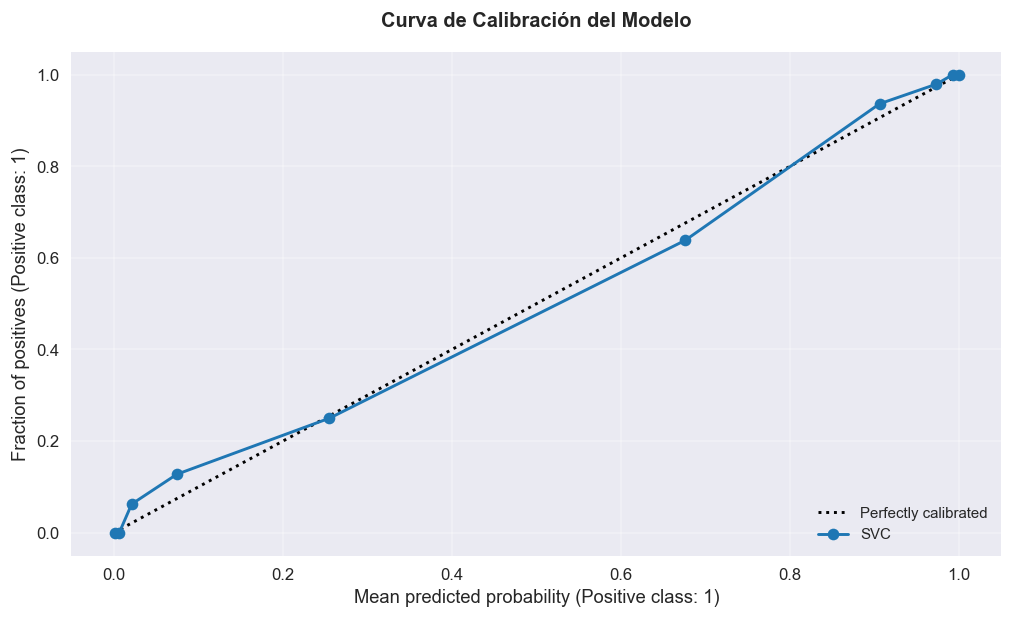

In [36]:
plt.figure(figsize=(10, 8))

# Crear subgráficos
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[3, 1])

# Curva de calibración
ax_calibration = plt.subplot(gs[0, :])
CalibrationDisplay.from_estimator(svm_model, X_test, y_test, n_bins=10, 
                                strategy='quantile', ax=ax_calibration,
                                color='#1f77b4', marker='o')
ax_calibration.grid(True, alpha=0.3)
ax_calibration.set_title('Curva de Calibración del Modelo', fontweight='bold', pad=15)

In [38]:
print("\n\n\033[1m" + "🔷 6. PERSISTENCIA DEL MODELO CON METADATOS" + "\033[0m")

# Crear metadatos completos
model_metadata = {
    'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'tiempo_entrenamiento_seg': round(training_time, 2),
    'metricas': {
        'entrenamiento': train_metrics,
        'validacion': val_metrics,
        'prueba': test_metrics
    },
    'hiperparametros': svm_model.get_params(),
    'caracteristicas': {
        'num_muestras_entrenamiento': len(X_train),
        'num_caracteristicas': X_train.shape[1],
        'vectores_soporte': len(svm_model.support_vectors_)
    },
    'rendimiento': {
        'accuracy_test': test_metrics['Exactitud'],
        'f1_score_test': test_metrics['F1-score'],
        'precision_test': test_metrics['Precisión'],
        'recall_test': test_metrics['Sensibilidad']
    }
}

# Guardar modelo y metadatos
model_path = 'modelos_entrenados/svm_basico_mejorado.pkl'
joblib.dump({'modelo': svm_model, 'metadata': model_metadata}, model_path)

print(f"✅ Modelo guardado en: {model_path}")
print("\n\033[1m📋 Resumen de metadatos:\033[0m")
display(pd.DataFrame.from_dict({
    'Fecha': model_metadata['fecha_entrenamiento'],
    'Tiempo Entrenamiento (s)': model_metadata['tiempo_entrenamiento_seg'],
    'Exactitud (Prueba)': f"{model_metadata['rendimiento']['accuracy_test']:.2%}",
    'F1-score (Prueba)': f"{model_metadata['rendimiento']['f1_score_test']:.2%}",
    'Vectores Soporte': model_metadata['caracteristicas']['vectores_soporte'],
    'Muestras Entrenamiento': model_metadata['caracteristicas']['num_muestras_entrenamiento']
}, orient='index', columns=['Valor']))

print("\n\033[1m🎉 ¡ANÁLISIS COMPLETADO CON ÉXITO! 🎉\033[0m")



🔷 6. PERSISTENCIA DEL MODELO CON METADATOS
✅ Modelo guardado en: modelos_entrenados/svm_basico_mejorado.pkl

📋 Resumen de metadatos:


,Valor
Fecha,2025-06-08 13:50:39
Tiempo Entrenamiento (s),3.06
Exactitud (Prueba),91.16%
F1-score (Prueba),91.14%
Vectores Soporte,1935
Muestras Entrenamiento,3800



🎉 ¡ANÁLISIS COMPLETADO CON ÉXITO! 🎉
